In [1]:
import pandas as pd
import glob
import os
import numpy as np
from tqdm import tqdm
import re

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')


false          7408
partly true    6451
true           1696
Name: labelCode, dtype: int64


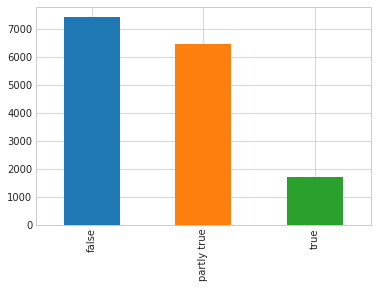

,claim,claimant,date,id,label,related_articles,labelCode
15550,"The omnibus spending bill has ""9,427 pork barr...",John McCain,2009-02-25,17137,2,"[82947, 93503]",true
15551,Representative Maxine Waters said Muslims were...,,2017-06-06,17138,0,"[103780, 104726, 126025]",false
15552,"""We were not, I repeat, were not told that wat...",Nancy Pelosi,2009-04-23,17139,0,"[11331, 68915, 2186, 2185, 88418, 81950]",false
15553,"As of August 2017, members of the public could...",,2018-05-14,17140,2,"[121353, 152864, 154411]",true
15554,"""We don't get any of that information"" from th...",Scott Walker,2016-12-23,17141,1,"[69545, 88929, 14698]",partly true


In [2]:
train = pd.read_json ('data/train.json')
labels = {0:'false', 1:'partly true', 2:'true'}

def label(x):
    return labels[x]

train['labelCode'] = train.label.apply(label)


print(train.labelCode.value_counts())

train.labelCode.value_counts().plot(kind='bar')

plt.show()
train.tail()


In [3]:
# print(glob.glob("data/train_articles/*.txt")[:100])
files = [f for f in glob.glob("data/train_articles/*.txt", recursive=True)]
# print(files[:10])

articles = []
for file in files:
    with open(file) as myfile:
        data= "".join(line.rstrip() for line in myfile)
        articles.append({'id' : os.path.basename(file)[:-4], 'text' : data})

articles_df = pd.DataFrame.from_dict(articles)
articles_df.reset_index(drop=True, inplace=True)
# articles_df.set_index('id', inplace=True)

articles_df.id = articles_df.id.astype(int)
articles_df.text = articles_df.text.apply(str)
# print(articles_df[articles_df.id == 112386]['text'])
# print(articles_df.describe())

articles_df.tail()

,id,text
64969,79940,"Rubio: Legalization first, border security whe..."
64970,81412,"Amid Health Law Expansion, Some States Trim Me..."
64971,112386,Library of CongressSenate Committee Any Commit...
64972,78733,Fort BraggFort Bragg is located just west of F...
64973,93980,Obama's Russia Reset a 'Disaster'articleChess ...


In [4]:

def clean_text(text):
    text =  re.sub(r'\W+', ' ', text).lower()
    text = re.sub("\d","#", text)
    return ' '.join([i for i in text.split() if len(i.strip()) > 1])
  
train['claim'] = train.claim.apply(clean_text)
articles_df['text'] = articles_df.text.apply(clean_text)


In [5]:
# print(train_df.iloc[0]['related_articles'][0])

train_complete = []
for index, row in tqdm(train.iterrows()):
    for article in row['related_articles']:
        train_complete.append(
            {
                'claim' : row['claim'],
                'claimant' : row['claimant'],
                'article' : articles_df.loc[articles_df['id'] == article].iloc[0]['text'],
                'date' : row['date'],
                'label' : row['label']
            }
        )
#     break

train_df = pd.DataFrame(train_complete)
# print(train.loc[1])
train_df.to_csv('data/full_train.cvs')
train_df = train_df.sample(frac=.10).reset_index(drop=True)

train_df.tail()

15555it [00:42, 361.82it/s]


,article,claim,claimant,date,label
7763,table ## induced abortion summary by woman rac...,more black babies are aborted in nyc than born,Cynthia Meyer,2015-11-14,2
7764,obama refuted by cdc report not true ## of wom...,at some point in their lives ## of women use b...,Susan Happ,2014-06-30,1
7765,could non citizens decide the november electio...,won the popular vote if you deduct the million...,Donald Trump,2016-11-28,0
7766,education and the artslocal control of public ...,the default rate for college students has grow...,Dennis Kucinich,2018-01-29,0
7767,the mercury theatre on the airthe finest radio...,orson welles ## october #### radio adaptation ...,,2018-10-31,1


Average word length of article in train is 1113.
Average claim length 22.353326904532306


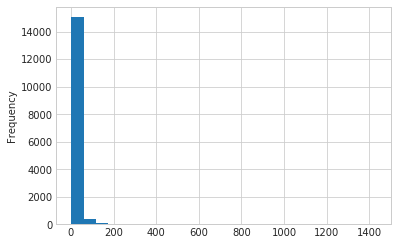

Average article length 1113.3399975374766


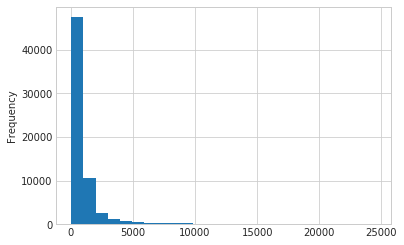

In [6]:
# print('Average word length of claim in train is {0:.0f}.'.format(np.mean(train['claim'].apply(lambda x: len(x.split())))))
print('Average word length of article in train is {0:.0f}.'.format(np.mean(articles_df['text'].apply(lambda x: len(x.split())))))

train['length'] = train['claim'].apply(lambda x: len(x.split()))
articles_df['length'] = articles_df['text'].apply(lambda x: len(x.split()))
print('Average claim length', train.length.mean())
train['length'].plot(bins=25, kind='hist')
plt.show()
print('Average article length', articles_df.length.mean())
articles_df['length'].plot(bins=25, kind='hist')

In [7]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils


X = train_df[['claim', 'article']]
y = train_df['label']

# encode class values as integers
encoder = LabelEncoder()
encoder.fit(y)
y = encoder.transform(y)
# convert integers to dummy variables (i.e. one hot encoded)
y = np_utils.to_categorical(y)


# print(y.tail())

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

print("num train: ", X_train.shape)
print("num test: ", y_train.shape)

X_train.tail()

Using TensorFlow backend.


num train:  (5204, 2)
num test:  (5204, 3)


,claim,article
5226,at this point in #### rick perry was ahead at ...,wh#### republicanswhite house #### republican ...
5390,criticizing the judge gonzalo curiel for his m...,trump personal racially tinged attacks on fede...
860,american schools are more segregated than they...,segregation now propublicasegregation now inve...
7603,note that we ve never even in the days of tsar...,russian foreign ministry distorts ukraine fami...
7270,the nfl fined players for violating league uni...,fine unlikely for avery williamson of tennesse...


In [8]:
label_names = ["true", "almost", "false"]
# y_train = train_df[label_names].values

# #visualize word distribution
# train_df['doc_len'] = train_df['comment_text'].apply(lambda words: len(words.split(" ")))
# max_seq_len = np.round(train_df['doc_len'].mean() + train_df['doc_len'].std()).astype(int)
# sns.distplot(train_df['doc_len'], hist=True, kde=True, color='b', label='doc len')
# plt.axvline(x=max_seq_len, color='k', linestyle='--', label='max len')
# plt.title('comment length'); plt.legend()
# plt.show()

In [9]:
from keras.preprocessing.text import Tokenizer
import string
from keras.preprocessing.sequence import pad_sequences

raw_docs_train = X_train['claim'].tolist()
raw_docs_test = X_test['claim'].tolist() 
num_classes = len(label_names)

X_train['doc_len'] =  X_train['claim'].apply(len)
X_test['doc_len'] =  X_test['claim'].apply(len)

MAX_NB_WORDS = 100000
max_seq_len = 300 #np.round(X_train['doc_len'].mean() + X_train['doc_len'].std()).astype(int)

from nltk.corpus import stopwords as sw
stopwords = sw
new_content, new_summary, new_query = [], [], []
stopwords = set(stopwords.words('english') + ["<eos>", "<s>"] + string.punctuation.split() + ";:><".split())

print("pre-processing train data...")
processed_docs_train = []
for doc in tqdm(raw_docs_train):
    filtered = [word for word in doc.split() if word not in stopwords]
    processed_docs_train.append(" ".join(filtered))
#end for

processed_docs_test = []
for doc in tqdm(raw_docs_test):
    filtered = [word for word in doc.split() if word not in stopwords]
    processed_docs_test.append(" ".join(filtered))
#end for

print("tokenizing input data...")
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, lower=True, char_level=False)
tokenizer.fit_on_texts(processed_docs_train + processed_docs_test)  #leaky
word_seq_train = tokenizer.texts_to_sequences(processed_docs_train)
word_seq_test = tokenizer.texts_to_sequences(processed_docs_test)
word_index = tokenizer.word_index
print("dictionary size: ", len(word_index))
nb_words = min(MAX_NB_WORDS, len(word_index))


#pad sequences
word_seq_train = pad_sequences(word_seq_train, maxlen=max_seq_len)
word_seq_test = pad_sequences(word_seq_test, maxlen=max_seq_len)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
100%|██████████| 2564/2564 [00:00<00:00, 297784.67it/s]


pre-processing train data...
tokenizing input data...
dictionary size:  12833


In [11]:
#training params
batch_size = 256 
num_epochs = 8 

#model parameters
num_filters = 64 
embed_dim = 300 
weight_decay = 1e-4


In [12]:
#load embeddings
import os, re, csv, math, codecs

print('loading word embeddings...')
embeddings_index = {}
f = codecs.open('/home/sonic/.keras/datasets/wiki-news-300d-1M.vec', encoding='utf-8')
for line in tqdm(f):
    values = line.rstrip().rsplit(' ')
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('found %s word vectors' % len(embeddings_index))

#embedding matrix
print('preparing embedding matrix...')
words_not_found = []
nb_words = min(MAX_NB_WORDS, len(word_index))
embedding_matrix = np.zeros((nb_words, embed_dim))
for word, i in word_index.items():
    if i >= nb_words:
        continue
    embedding_vector = embeddings_index.get(word)
    if (embedding_vector is not None) and len(embedding_vector) > 0:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
    else:
        words_not_found.append(word)
print('number of null word embeddings: %d' % np.sum(np.sum(embedding_matrix, axis=1) == 0))
print("sample words not found: ", np.random.choice(words_not_found, 10))

1592it [00:00, 15915.31it/s]

loading word embeddings...


999995it [01:09, 14400.43it/s]

found 999995 word vectors
preparing embedding matrix...
number of null word embeddings: 1131
sample words not found:  ['broward' 'fatbellybella' 'rkbez' 'tldmorg' 'desantis' 'begich' 'xvym'
 'abubakar' 'uhhhpat' 'steptococcus']


In [21]:
import keras
import tensorflow
from keras_self_attention import SeqSelfAttention

from keras.layers import Flatten, Dropout, Bidirectional, GRU
from keras.layers import Embedding, Dense
from keras.models import Sequential


model = Sequential()

model.add(Embedding(nb_words, embed_dim,
          weights=[embedding_matrix], input_length=max_seq_len, trainable=False))

model.add(Bidirectional(GRU(units=128, return_sequences=True)))
model.add(SeqSelfAttention(attention_activation='sigmoid'))
model.add(Dropout(rate=0.2))
model.add(Flatten())
model.add(Dense(units=3))
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['categorical_accuracy'],
)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 300, 300)          3849900   
_________________________________________________________________
bidirectional_4 (Bidirection (None, 300, 256)          329472    
_________________________________________________________________
seq_self_attention_6 (SeqSel (None, 300, 256)          16449     
_________________________________________________________________
dropout_3 (Dropout)          (None, 300, 256)          0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 76800)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 230403    
Total params: 4,426,224
Trainable params: 576,324
Non-trainable params: 3,849,900
____________________________________________________________

In [22]:
#model training
hist = model.fit(word_seq_train, y_train, batch_size=batch_size, 
                 epochs=num_epochs, # callbacks=callbacks_list,
                 validation_split=0.1, shuffle=True, verbose=1)

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Train on 4683 samples, validate on 521 samples
Epoch 1/8
4683/4683 [==============================] - 93s 20ms/step - loss: 1.3348 - categorical_accuracy: 0.4258 - val_loss: 0.9948 - val_categorical_accuracy: 0.5029
Epoch 2/8
4683/4683 [==============================] - 92s 20ms/step - loss: 0.9587 - categorical_accuracy: 0.5054 - val_loss: 0.9271 - val_categorical_accuracy: 0.4933
Epoch 3/8
4683/4683 [==============================] - 92s 20ms/step - loss: 0.9425 - categorical_accuracy: 0.5020 - val_loss: 0.9240 - val_categorical_accuracy: 0.4933
Epoch 4/8
4683/4683 [==============================] - 92s 20ms/step - loss: 0.9375 - categorical_accuracy: 0.5022 - val_loss: 0.9248 - val_categorical_accuracy: 0.4933
Epoch 5/8
4683/4683 [==============================] - 92s 20ms/step - loss: 0.9355 - categorical_accuracy: 0.5020 - val_loss: 0.9217 - val_categorical

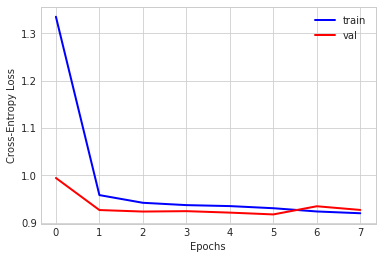

In [24]:
def plot_history(hist):
    #generate plots
    plt.figure()
    plt.plot(hist.history['loss'], lw=2.0, color='b', label='train')
    plt.plot(hist.history['val_loss'], lw=2.0, color='r', label='val')
    plt.xlabel('Epochs')
    plt.ylabel('Cross-Entropy Loss')
    plt.legend(loc='upper right')
    plt.show()

#     plt.figure()
#     plt.plot(hist.history['acc'], lw=2.0, color='b', label='train')
#     plt.plot(hist.history['val_acc'], lw=2.0, color='r', label='val')
#     plt.xlabel('Epochs')
#     plt.ylabel('Accuracy')
#     plt.legend(loc='upper left')
#     plt.show()

plot_history(hist)

In [25]:
y_test = model.predict(word_seq_test)


InvalidArgumentError: indices[3,286] = 12833 is not in [0, 12833)
	 [[{{node embedding_5/embedding_lookup}}]]

In [ ]:
# Results
print('sklearn Macro-F1-Score:', f1_score(y_true, y_pred, average='macro'))

In [27]:
print('X_test', X_test.shape)
print()
y_pred = model.predict(X_test)
print(y_pred.shape, y_pred[:10])

print(np.unique(y_pred))


def decode(data):
    decoded = []
    for i in range(data.shape[0]):
        print('sssss', data[i], np.argmax(data[i]))
        decoded.append(np.argmax(data[i]))
        break
    
    return np.asanyarray(decoded)

print(decode(y_pred)[:10])
print()

y_pred = decode(y_pred)
y_true = decode(y_test)

print(np.unique(y_pred))
print(np.unique(y_true))
print(y_pred)
print(y_pred.shape)
print(y_test.shape)
from sklearn.metrics import f1_score, classification_report

# Results
print('sklearn Macro-F1-Score:', f1_score(y_true, y_pred, average='macro'))
print('sklearn Micro-F1-Score:', f1_score(y_true, y_pred, average='micro'))  
print('sklearn weighted-F1-Score:', f1_score(y_true, y_pred, average='weighted'))  
print('sklearn no average-F1-Score:', f1_score(y_true, y_pred, average=None))

print(classification_report(y_true, y_pred))

X_test (2564, 3)


ValueError: Error when checking input: expected embedding_5_input to have shape (300,) but got array with shape (3,)

In [ ]:

# evaluate the model
loss, accuracy = model.evaluate(X_test, y_test, verbose=2)
print('Accuracy: %f' % (accuracy*100))